### IMPORTS

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
import umap.umap_ as umap
import prince
import pacmap
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import pacmap
from sklearn.manifold import MDS

c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### LOAD DATA

In [2]:
df = pd.read_csv("penguins.csv").dropna()

### EMBEDDINGS

#### UMAP

In [3]:
numerical = df.select_dtypes('number')
categorical = df.select_dtypes('object')
scaler = StandardScaler()
numerical = scaler.fit_transform(numerical)
categorical = categorical.apply(lambda x: x.replace(x.unique(),list(range(1,1+len(x.unique())))))
gamma = np.mean(np.std(numerical))/2
distances = (cdist(numerical,numerical,'sqeuclidean')) + cdist(categorical,categorical,'hamming')*gamma
umap_embedding = umap.UMAP(n_components=len(df.columns),metric="precomputed").fit_transform(distances)

c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


#### FAMD

In [4]:
famd = prince.FAMD(len(df.columns))
famd_embeddings = famd.fit_transform(df)

#### Split PaCMAP

In [5]:
#numerical = df2.select_dtypes(exclude='object')
#for c in numerical.columns:
#    numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)
#categorical = df2.select_dtypes(include='object')
#categorical = pd.get_dummies(categorical)
n_components = np.min([np.min(categorical.shape), np.min(numerical.shape)])
fit1 = pacmap.PaCMAP(n_components=n_components).fit_transform(numerical)
fit2 = pacmap.PaCMAP(distance='hamming',n_components=n_components).fit_transform(categorical)
pacmap_embeddings = np.square(fit1)+fit2*gamma

c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\pacmap\pacmap.py:835: UserWarning: apply_pca = True for Hamming distance. This option will be ignored.
  warnings.warn(


#### MDS + PaCMAP because no doc and sklearn API not really respected and it wont work squalala

In [6]:
model = MDS(n_components=len(df.columns)*5,dissimilarity='precomputed', max_iter=2000)
mds_emb = model.fit(distances).embedding_
mds_pacmap_embeddings=pacmap.PaCMAP(n_components=np.min(mds_emb.shape), apply_pca=True).fit_transform(mds_emb)

In [7]:
mds_emb.shape

(333, 40)

In [8]:
np.nanmean(distances/cdist(mds_emb, mds_emb))

C:\Users\cleme\AppData\Local\Temp\ipykernel_22988\2209206624.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean(distances/cdist(mds_emb, mds_emb))


0.8701546900083946

### EVALUATE

In [9]:
results = pd.DataFrame()
umap_results = []
famd_results = []
pacmap_results = []
mds_pacmap_results = []
for k in range(2,20):
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(umap_embedding)
    umap_results.append(davies_bouldin_score(umap_embedding, clusters))
    famd_results.append(davies_bouldin_score(famd_embeddings, clusters))
    pacmap_results.append(davies_bouldin_score(pacmap_embeddings, clusters))
    mds_pacmap_results.append(davies_bouldin_score(mds_pacmap_embeddings, clusters))
results['UMAP'] = umap_results
results['FAMD'] = famd_results
results['PaCMAP'] = pacmap_results
results['MDS-PaCMAP'] = mds_pacmap_results
results.index += 2

In [10]:
results

,UMAP,FAMD,PaCMAP,MDS-PaCMAP
2,0.735493,1.098335,1.041330,0.783903
3,0.494766,2.354644,1.079409,0.862166
4,0.374937,2.427648,1.229626,0.945545
5,0.320527,3.400868,1.125659,0.673016
6,0.275511,3.499838,0.883550,0.626709
7,0.311870,2.984812,0.855754,0.692650
8,0.380386,2.605937,0.955154,0.736035
9,0.437402,3.011953,0.956710,0.761374
10,0.467809,2.499797,0.924886,0.754637
11,0.453026,2.055848,0.937083,0.820523


In [11]:
import markov_clustering as mc
import networkx as nx
import random

adj = np.exp(-(distances ** 2))
#
#component_embedding = SpectralEmbedding(
#    n_components=ldn(df.columns), affinity="precomputed", random_state=random_state
#).fit_transform(affinity_matrix)
#component_embedding /= component_embedding.max()
result = mc.run_mcl(adj)           # run MCL with default parameters
clusters = mc.get_clusters(result)

In [12]:
len(clusters)

24

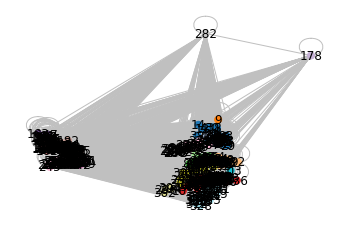

In [13]:
mc.draw_graph(adj, clusters, node_size=50, with_labels=True, edge_color="silver")

In [14]:
sum(len(i) for i in clusters)

333

In [15]:
heu = umap.UMAP(n_components=len(df.columns),metric="precomputed")
heu.fit(distances)
heu.graph_

c:\Users\cleme\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


<333x333 sparse matrix of type '<class 'numpy.float32'>'
	with 5724 stored elements in Compressed Sparse Row format>

In [16]:
heu.graph_

<333x333 sparse matrix of type '<class 'numpy.float32'>'
	with 5724 stored elements in Compressed Sparse Row format>

In [17]:
adj

array([[1.00000000e+000, 5.77767267e-001, 5.02809125e-002, ...,
        2.38080672e-052, 4.29750688e-105, 3.76063841e-065],
       [5.77767267e-001, 1.00000000e+000, 3.70743815e-001, ...,
        8.86668400e-048, 3.02383912e-093, 2.44309524e-057],
       [5.02809125e-002, 3.70743815e-001, 1.00000000e+000, ...,
        1.54104470e-043, 8.25535927e-072, 1.02908721e-046],
       ...,
       [2.38080672e-052, 8.86668400e-048, 1.54104470e-043, ...,
        1.00000000e+000, 3.22899865e-002, 8.71378929e-001],
       [4.29750688e-105, 3.02383912e-093, 8.25535927e-072, ...,
        3.22899865e-002, 1.00000000e+000, 2.97759587e-001],
       [3.76063841e-065, 2.44309524e-057, 1.02908721e-046, ...,
        8.71378929e-001, 2.97759587e-001, 1.00000000e+000]])

In [19]:
zz = heu.graph_
print(np.nanmean(adj/zz.A))
adj = zz.A

result = mc.run_mcl(adj)           # run MCL with default parameters
clusters = mc.get_clusters(result)

inf


C:\Users\cleme\AppData\Local\Temp\ipykernel_22988\3956440947.py:2: RuntimeWarning: divide by zero encountered in divide
  print(np.nanmean(adj/zz.A))
C:\Users\cleme\AppData\Local\Temp\ipykernel_22988\3956440947.py:2: RuntimeWarning: invalid value encountered in divide
  print(np.nanmean(adj/zz.A))


In [20]:
len(clusters)

29

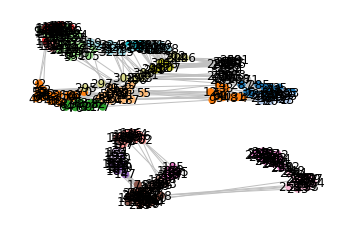

In [21]:
mc.draw_graph(adj, clusters, node_size=50, with_labels=True, edge_color="silver")